import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Sequence, Tuple
from antea.elec import tof_functions as wvf 
from scipy import signal
import fit_library as fl
%matplotlib nbagg
%reload_ext autoreload
%autoreload 2

# Time unit (tu) -> 100 ps
# Simulation Time Step -> 5ns (50 tu)
time_unit = 100E-12
time_step = 1 #tu
pe_density = 1 / 5000 #tu
pe_peak = 20.9 #uA
SiPM_gain = 1.04E-12 #pC
n_pe_total = 2
delay = 2000
data_file = 'sensor_data_csi_100ps.csv'

# Waveform generator
def wave_gen(pe_time_zs:np.array) -> Tuple[np.array,np.array,np.array]:
    
    spe_response_norm_Q,norm = wvf.apply_spe_dist(np.arange(0,4000),[10,400])
    spe_response = spe_response_norm_Q*SiPM_gain/time_unit # current conversion
    time = np.arange(0,pe_time_zs[0,-1]*time_step+len(spe_response))
    pe   = np.zeros(pe_time_zs[0,-1].astype('int')*time_step+len(spe_response)) 
    pe[pe_time_zs[0,:].astype('int')*time_step] = pe_time_zs[1,:]  
    
    # C. Romo convolution
    #wave = wvf.convolve_tof(spe_response,pe)
    wave = np.convolve(spe_response,pe)
    return time,wave,pe

def filter_bilinear(num, den, f_sample, signal_in):
    hz = signal.bilinear(num, den, f_sample)
    filter_out = signal.lfilter(hz[0],hz[1],signal_in)
    return filter_out, hz

# Data Selection

with open('/data_phys/' + data_file,'rb') as csv_file:       
        data_pe = pd.read_csv(csv_file)

energy_array = []
for i in range(124,991):
    event_i = data_pe[data_pe['event']==i]
    energy_i = np.sum(event_i['charge'])
    energy_array = np.append(energy_array,energy_i)

high_pos = np.argwhere(energy_array > 32000) + 124

data_HE_22 = data_pe[(data_pe['event']==high_pos[10][0]) & (data_pe['sensor_id']==22)]
time_HE_sparse = np.array(data_HE_22['time'])
pe_HE = np.array(data_HE_22['charge'])
time_HE,wave_HE,pe_HE = wave_gen(np.vstack([time_HE_sparse,pe_HE]))
wave_HE = wave_HE
wave_pileup = np.concatenate((wave_HE,np.zeros(8000))) + np.concatenate((np.zeros(8000),wave_HE))
wave_pileup2 = np.concatenate((wave_HE,np.zeros(16000))) + np.concatenate((np.zeros(16000),wave_HE))

# Filtering

# PILEUP SIGNALS
f_sample = 1/time_unit
wa = 1.8E6*2*np.pi
wb = 1.8E6*2*np.pi
num_dev = [1/wa,0]
den_dev1 = [1/wa,1]
den_dev2 = [1/wb,1]
den_dev = np.convolve(den_dev1,den_dev2)

filter_out, hz = filter_bilinear(num_dev, den_dev, f_sample, wave_pileup2)

wc = 0.4E6*2*np.pi
num_lpf = [1]
den_lpf = [1/wc, 1]
lpf_out, hz = filter_bilinear(num_lpf, den_lpf, f_sample, wave_pileup2)
norm = np.max(lpf_out)
lpf_out = lpf_out / norm
filter_out2, hz = filter_bilinear(num_dev, den_dev, f_sample, lpf_out)
filter_out2 = filter_out2 / np.max(filter_out2)

# FIRST PULSE
first_pulse = np.concatenate((wave_HE,np.zeros(16000)))
first_pulse_lpf, hz = filter_bilinear(num_lpf, den_lpf, f_sample, first_pulse)
first_pulse_lpf = first_pulse_lpf / norm

df = pd.DataFrame({'time': np.arange(0,70000)/10,'lpf_out':lpf_out[0:70000], 
                   'first_pulse_lpf':first_pulse_lpf[0:70000], 
                   'first_pulse':first_pulse[0:70000],
                   'filter_out2':filter_out2[0:70000] })
df.to_hdf('data_plots.h5', key='df', mode='w') 

In [72]:
df_read = pd.read_hdf('data_plots.h5',key="df")

time_p    = np.array(df_read['time'])
lpf_out_p = np.array(df_read['lpf_out'])
first_pulse_lpf_p = np.array(df_read['first_pulse_lpf'])
first_pulse_p = np.array(df_read['first_pulse'])
filter_out2_p = np.array(df_read['filter_out2'])

<IPython.core.display.Javascript object>


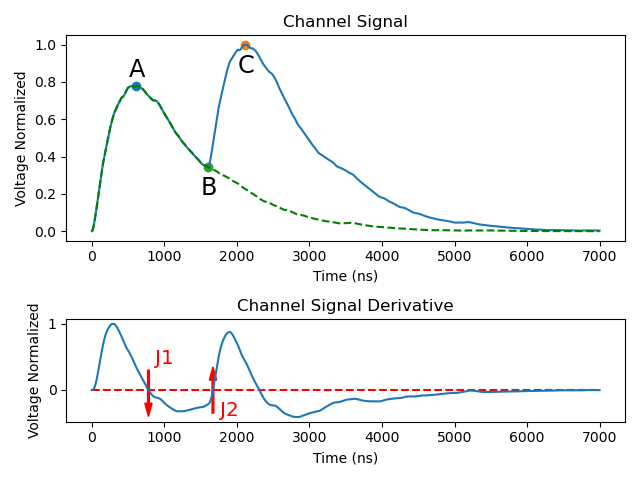

In [73]:
fig, axis = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]})
axis[0].plot(time_p,lpf_out_p)
axis[0].plot(time_p, first_pulse_lpf_p,'g', linestyle='dashed')

axis[1].plot(time_p,filter_out2_p)
axis[1].hlines(0,0,7000, colors='r', linestyles='dashed')

axis[0].set_title("Channel Signal")
axis[0].set_xlabel("Time (ns)")
axis[0].set_ylabel("Voltage Normalized")
axis[1].set_title("Channel Signal Derivative")
axis[1].set_xlabel("Time (ns)")
axis[1].set_ylabel("Voltage Normalized")

Ay = np.max(first_pulse_lpf_p)
Ax = np.argmax(first_pulse_lpf_p)/10
axis[0].scatter(Ax,Ay)
axis[0].text(Ax-100,Ay+0.05,"A",fontsize='xx-large')

Cy = np.max(lpf_out_p)
Cx = np.argmax(lpf_out_p)/10
axis[0].scatter(Cx,Cy)
axis[0].text(Cx-100,Cy-0.15,"C",fontsize='xx-large')

By = 0.344
Bx = 1604
axis[0].scatter(Bx,By)
axis[0].text(Bx-100,By-0.15,"B",fontsize='xx-large')

axis[1].arrow(781,0.3,0,-0.5,width=25, head_width=100, head_length=0.2, color='r')
axis[1].text(870,0.4,"J1",fontsize='x-large',color='r')
axis[1].arrow(1670,-0.35,0,0.5,width=25, head_width=100, head_length=0.2, color='r')
axis[1].text(1770,-0.4,"J2",fontsize='x-large',color='r')

fig.tight_layout()

<IPython.core.display.Javascript object>


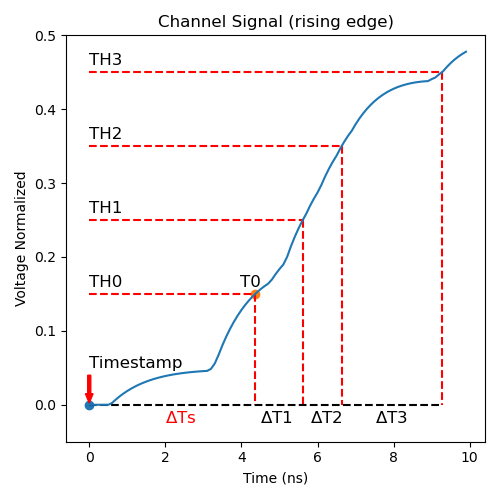

In [74]:
fig = plt.figure(figsize=(5,5)) 
axis1 = fig.add_subplot(111) 
axis1.plot(time_p[0:100],first_pulse_p[0:100]*1000) 
axis1.set_title("Channel Signal (rising edge)")
axis1.set_xlabel("Time (ns)")
axis1.set_ylabel("Voltage Normalized")

axis1.hlines(0.15,0,4.362, colors='r', linestyles='dashed')
axis1.hlines(0.25,0,5.611, colors='r', linestyles='dashed')
axis1.hlines(0.35,0,6.633, colors='r', linestyles='dashed')
axis1.hlines(0.45,0,9.263, colors='r', linestyles='dashed')

axis1.vlines(4.362,0.15,0, colors='r', linestyles='dashed')
axis1.vlines(5.611,0.25,0, colors='r', linestyles='dashed')
axis1.vlines(6.633,0.35,0, colors='r', linestyles='dashed')
axis1.vlines(9.263,0.45,0, colors='r', linestyles='dashed')

axis1.hlines(0,0,9.263, colors='black', linestyles='dashed')

TSy = 0
TSx = 0
axis1.scatter(TSx,TSy)
axis1.text(TSx,TSy+0.05,"Timestamp",fontsize='large')
axis1.arrow(TSx,TSy+0.04,0,-0.025,width=0.08, head_width=0.2, head_length=0.0125, color='r')

T0y = 0.15
T0x = 4.362
axis1.scatter(T0x,T0y)
axis1.text(T0x-0.4,T0y+0.01,"T0",fontsize='large')

axis1.text(0,T0y+0.01,"TH0",fontsize='large')
axis1.text(0,T0y+0.1+0.01,"TH1",fontsize='large')
axis1.text(0,T0y+0.2+0.01,"TH2",fontsize='large')
axis1.text(0,T0y+0.3+0.01,"TH3",fontsize='large')

axis1.set_ylim([-0.05, 0.5])

axis1.text(2,-0.025,"$\Delta$Ts",fontsize='large',color='r')
axis1.text(4.5,-0.025,"$\Delta$T1",fontsize='large')
axis1.text(5.8,-0.025,"$\Delta$T2",fontsize='large')
axis1.text(7.5,-0.025,"$\Delta$T3",fontsize='large')

fig.tight_layout()